IMPORTING VARIOUS MODULES AND USING TENSORFLOW 

In [ ]:
import numpy as np
import pandas as pd
from skimage import io,exposure
from sklearn.utils import shuffle
import matplotlib.pyplot as plot
import os
from random import randint
from skimage.color import rgb2gray
from skimage.transform import resize
import matplotlib.gridspec as gridspec
from skimage.morphology import disk
from skimage.filters import rank
from skimage.util import img_as_ubyte
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import tensorflow.keras.utils as Utils
import tensorflow as tf
import keras
from keras import models
from keras.layers import Dense, Dropout, Flatten,Conv2D, MaxPooling2D, BatchNormalization
from keras import regularizers
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

READING THE DATA

In [ ]:
image_list=[]
labels=[]
path = '/content/drive/MyDrive/Dataset/Human/'

for subdir, dirs, files in os.walk(path):
    for file in files:
        image=io.imread(os.path.join(subdir, file))
        grayscale = rgb2gray(image)
        resized=resize(grayscale, (200, 200))
        image_list.append(resized)
        labels.append(subdir.split('/')[-1])

image_list,labels=shuffle(image_list,labels)

PLOTTING THE DATA

In [ ]:
plot_images=image_list[:25]
plot_labels=labels[:25]

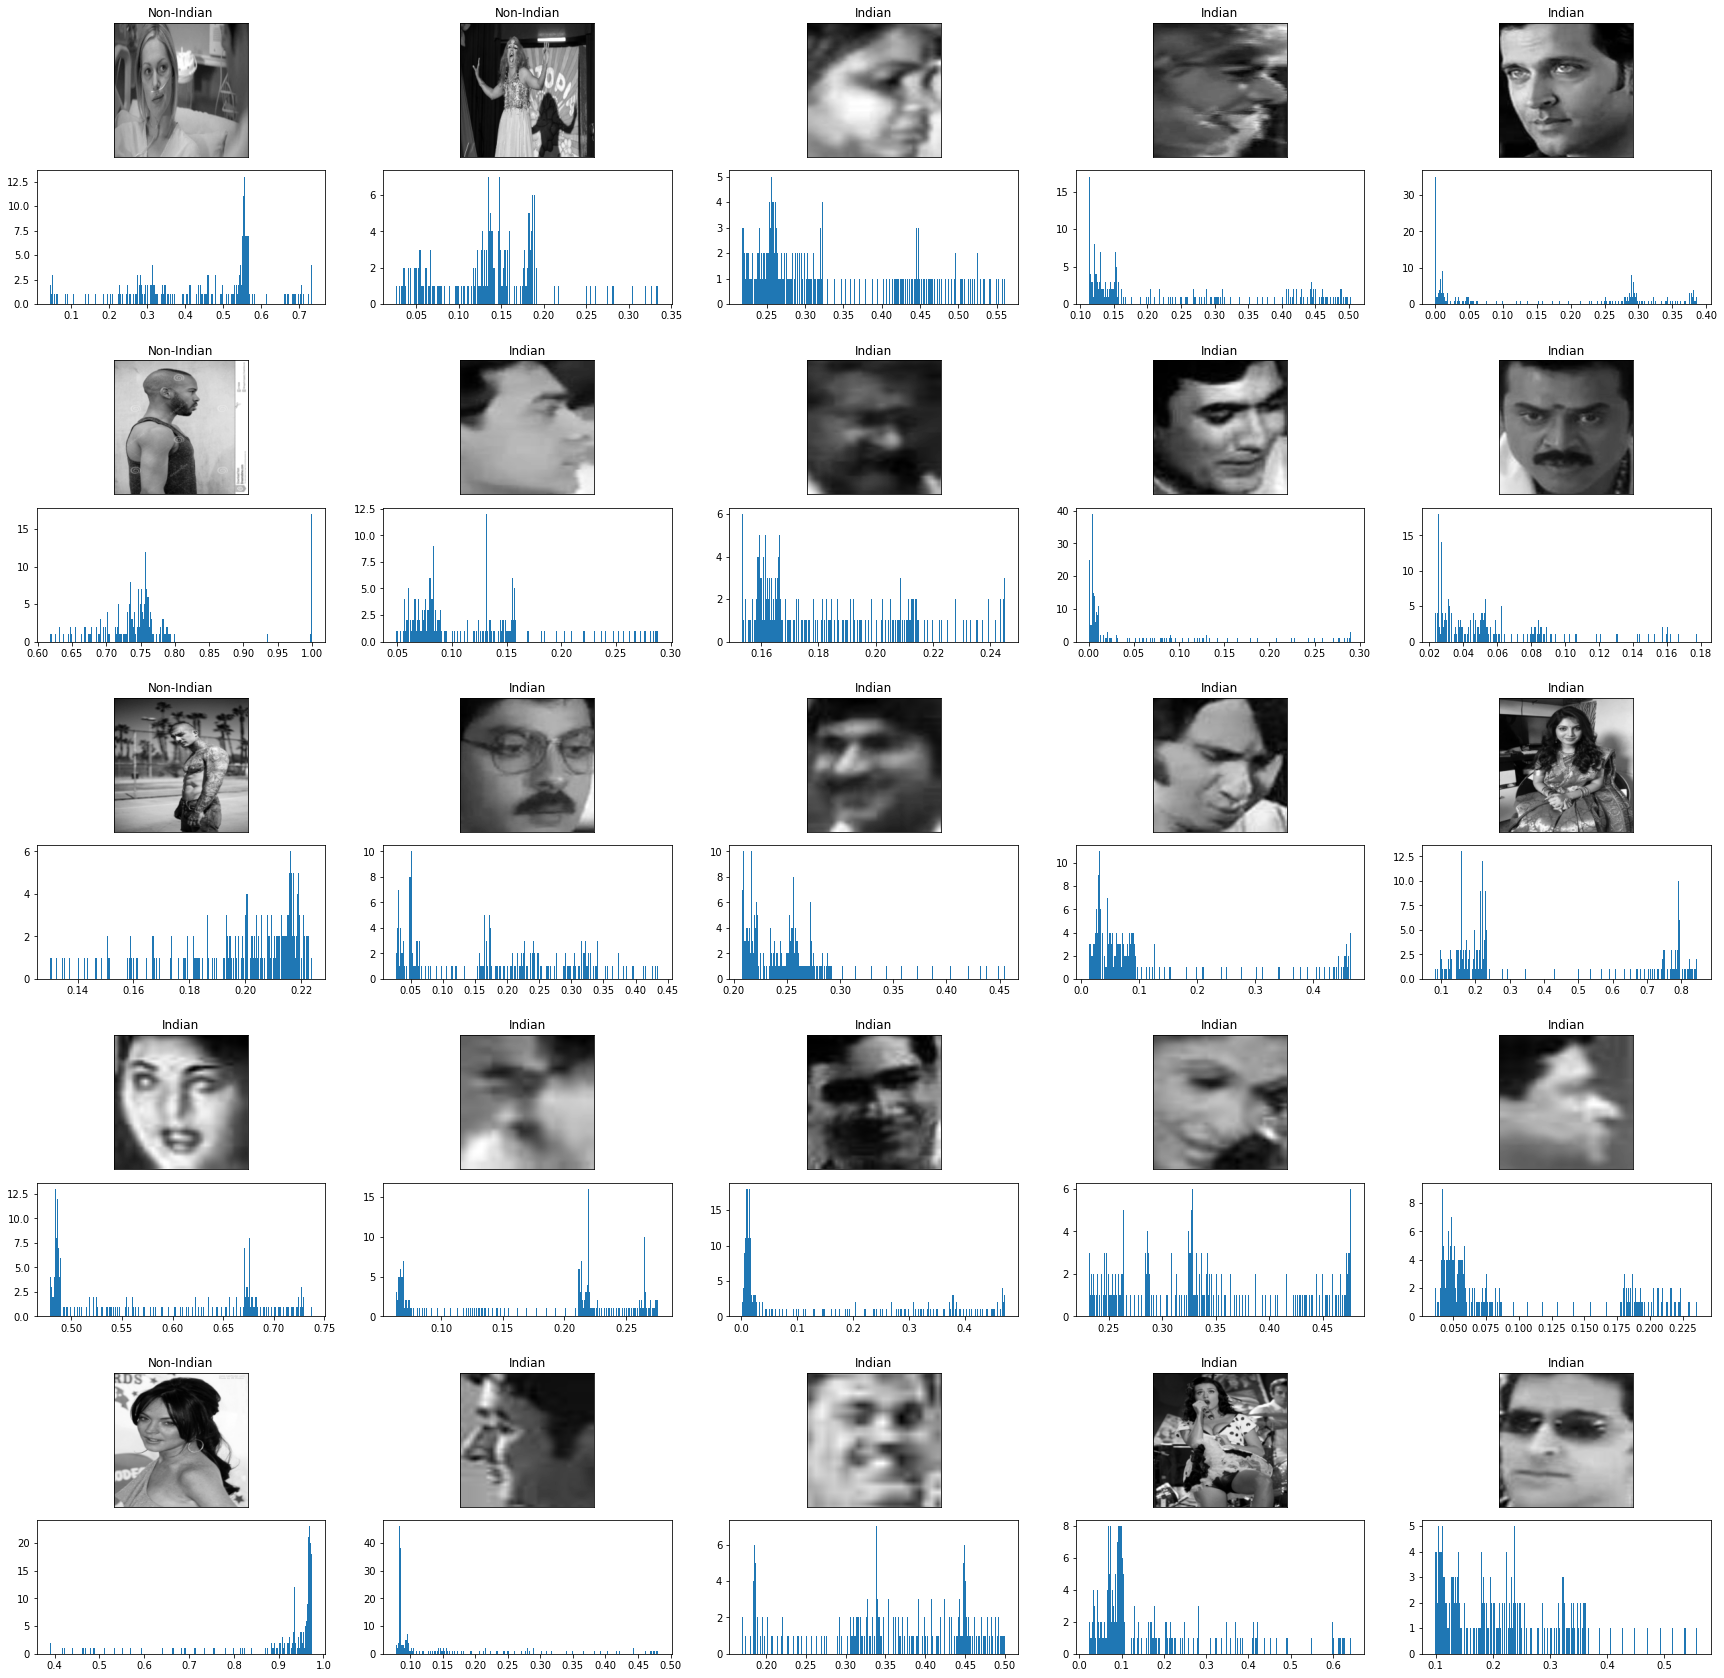

In [ ]:
fig = plot.figure(figsize=(30, 30))
outer = gridspec.GridSpec(5, 5, wspace=0.2, hspace=0.2)
s=0
for i,k in zip(plot_images,plot_labels):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,subplot_spec=outer[s], wspace=0.1, hspace=0.1)
    s+=1
    for j in range(2):
        if (j%2) == 0:
            ax = plot.Subplot(fig, inner[j])
            ax.imshow(i,cmap='gray')
            ax.set_title(k)
            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)
        else:
            ax = plot.Subplot(fig, inner[j])
            ax.hist(i[0],bins=256,histtype='bar')
            fig.add_subplot(ax)         
fig.show()

IMAGE ENHANCEMENT

In [ ]:
random_index = randint(0,len(image_list))


comparison_list = []
comparison_lable = []

#orignal
comparison_list.append(image_list[random_index])
comparison_lable.append("Orignal")

# Contrast stretching
p2, p98 = np.percentile(image_list[random_index], (2, 98))
comparison_list.append(exposure.rescale_intensity(image_list[random_index], in_range=(p2, p98)))
comparison_lable.append("Contrast stretching")


#Global Equalization
comparison_list.append(exposure.equalize_hist(image_list[random_index]))
comparison_lable.append("Equalization")

#local Equalization
selem = disk(60)
comparison_list.append(rank.equalize(img_as_ubyte(image_list[random_index]), selem=selem))
comparison_lable.append("Local Equalization")

# Adaptive Equalization
comparison_list.append(exposure.equalize_adapthist(image_list[random_index], clip_limit=0.3))
comparison_lable.append("Adaptive Equalization")

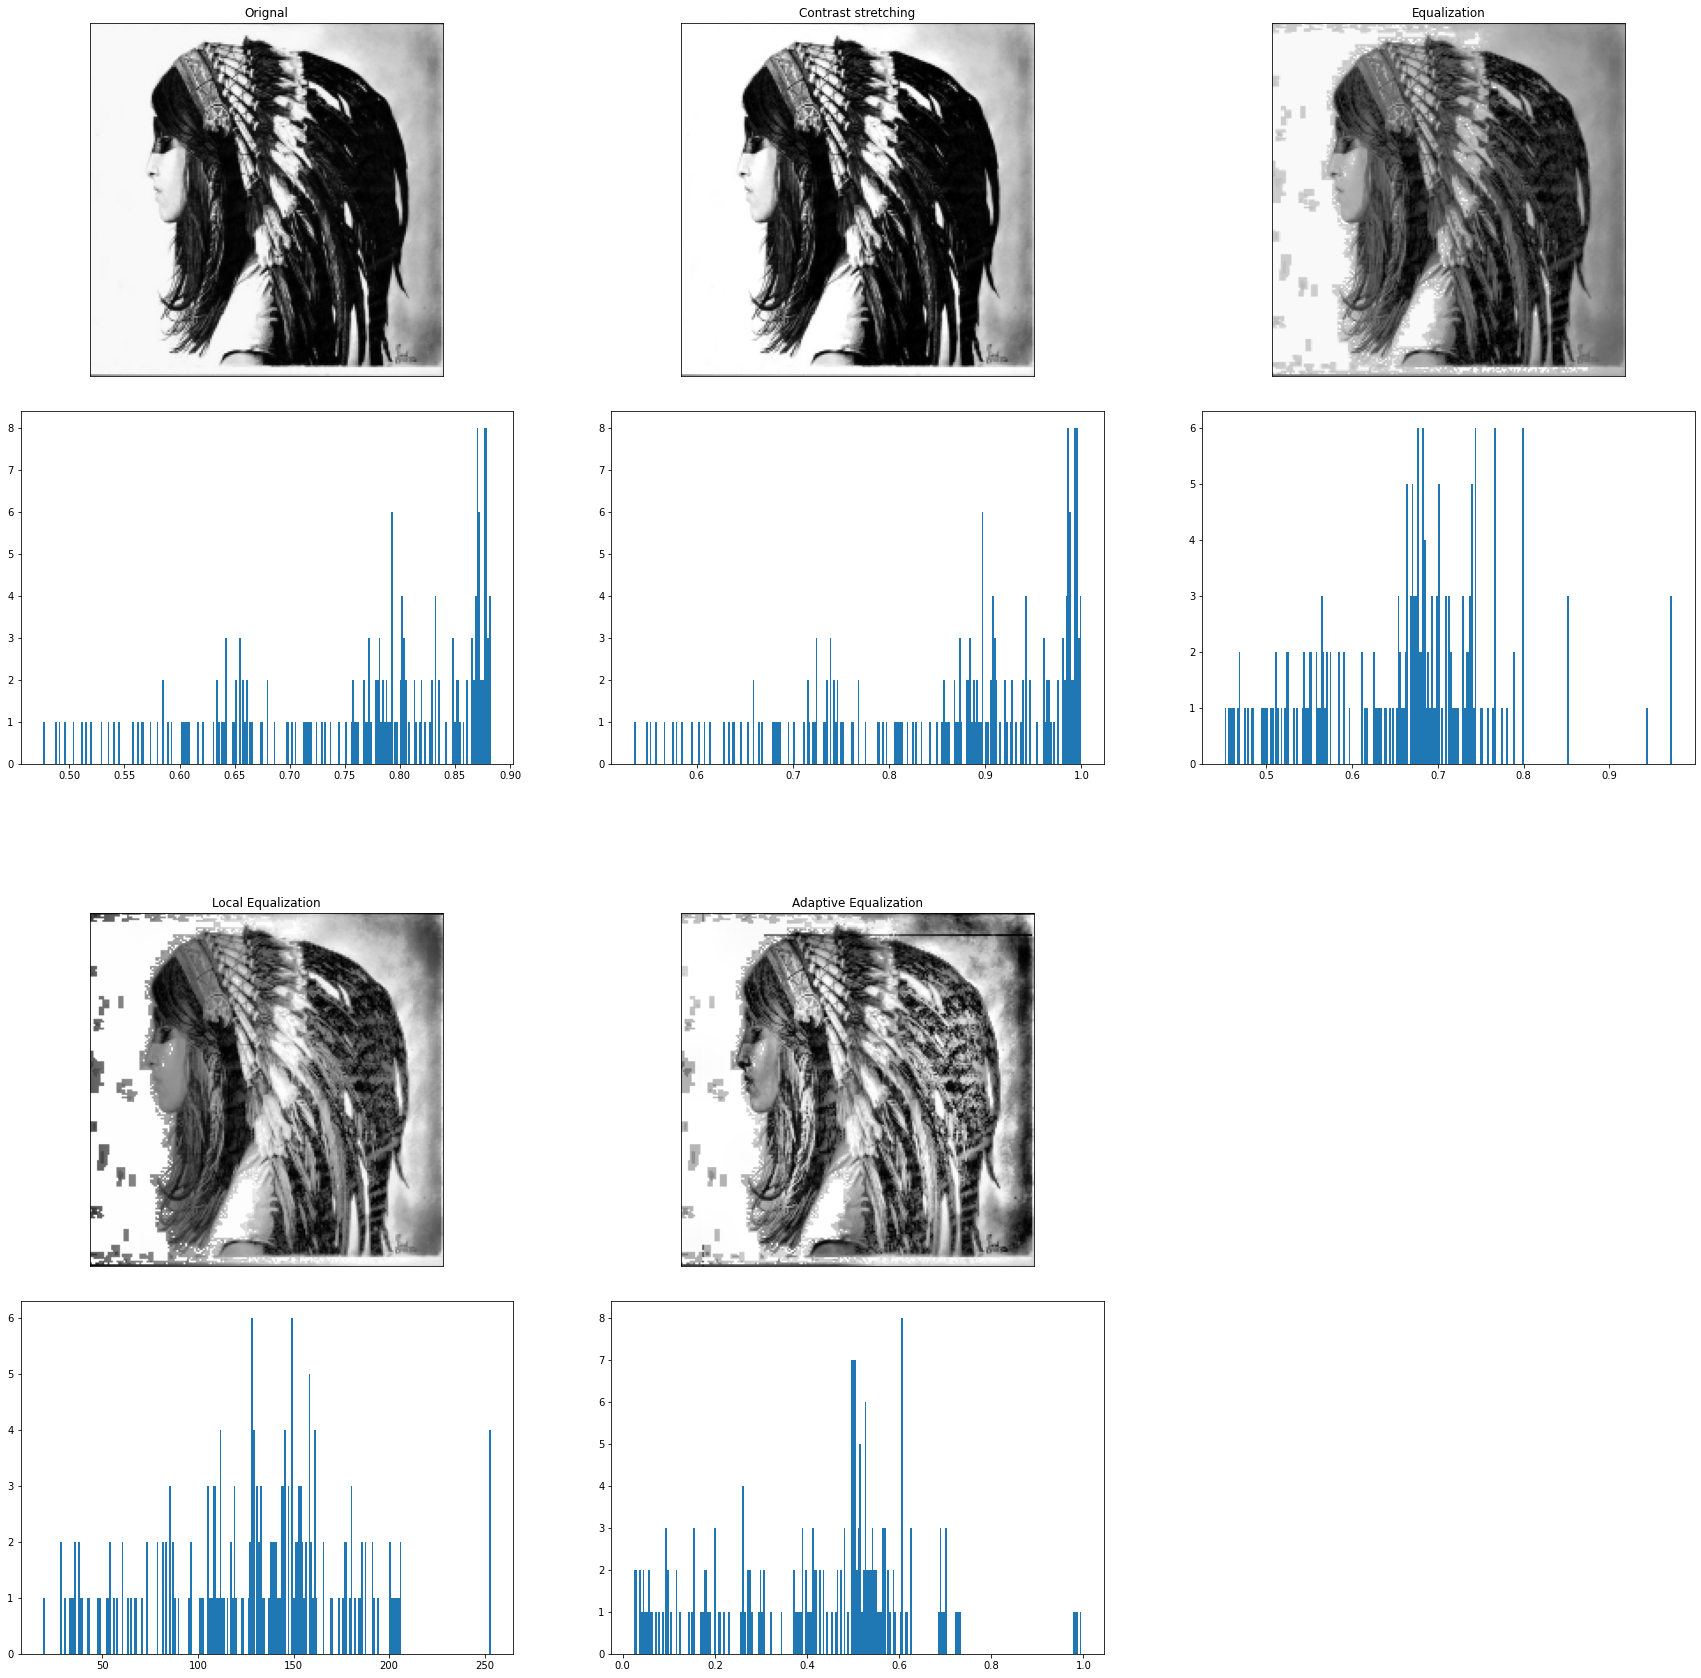

In [ ]:
fig = plot.figure(figsize=(30, 30))
outer = gridspec.GridSpec(2, 3, wspace=0.2, hspace=0.2)
s=0
for i,k in zip(comparison_list,comparison_lable):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,subplot_spec=outer[s], wspace=0.1, hspace=0.1)
    s+=1
    for j in range(2):
        if (j%2) == 0:
            ax = plot.Subplot(fig, inner[j])
            ax.imshow(i,cmap='gray')
            ax.set_title(k)
            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)
        else:
            ax = plot.Subplot(fig, inner[j])
            ax.hist(i[0],bins=256,histtype='bar')
            fig.add_subplot(ax)
fig.show()

In [ ]:
#This is the enhancement cell
for i in range(0,len(image_list)):
    image_list[i] = exposure.equalize_hist(image_list[i])

In [ ]:
plot_images=image_list[:25]
plot_labels=labels[:25]

In [ ]:
plot_images[0].shape

(200, 200)

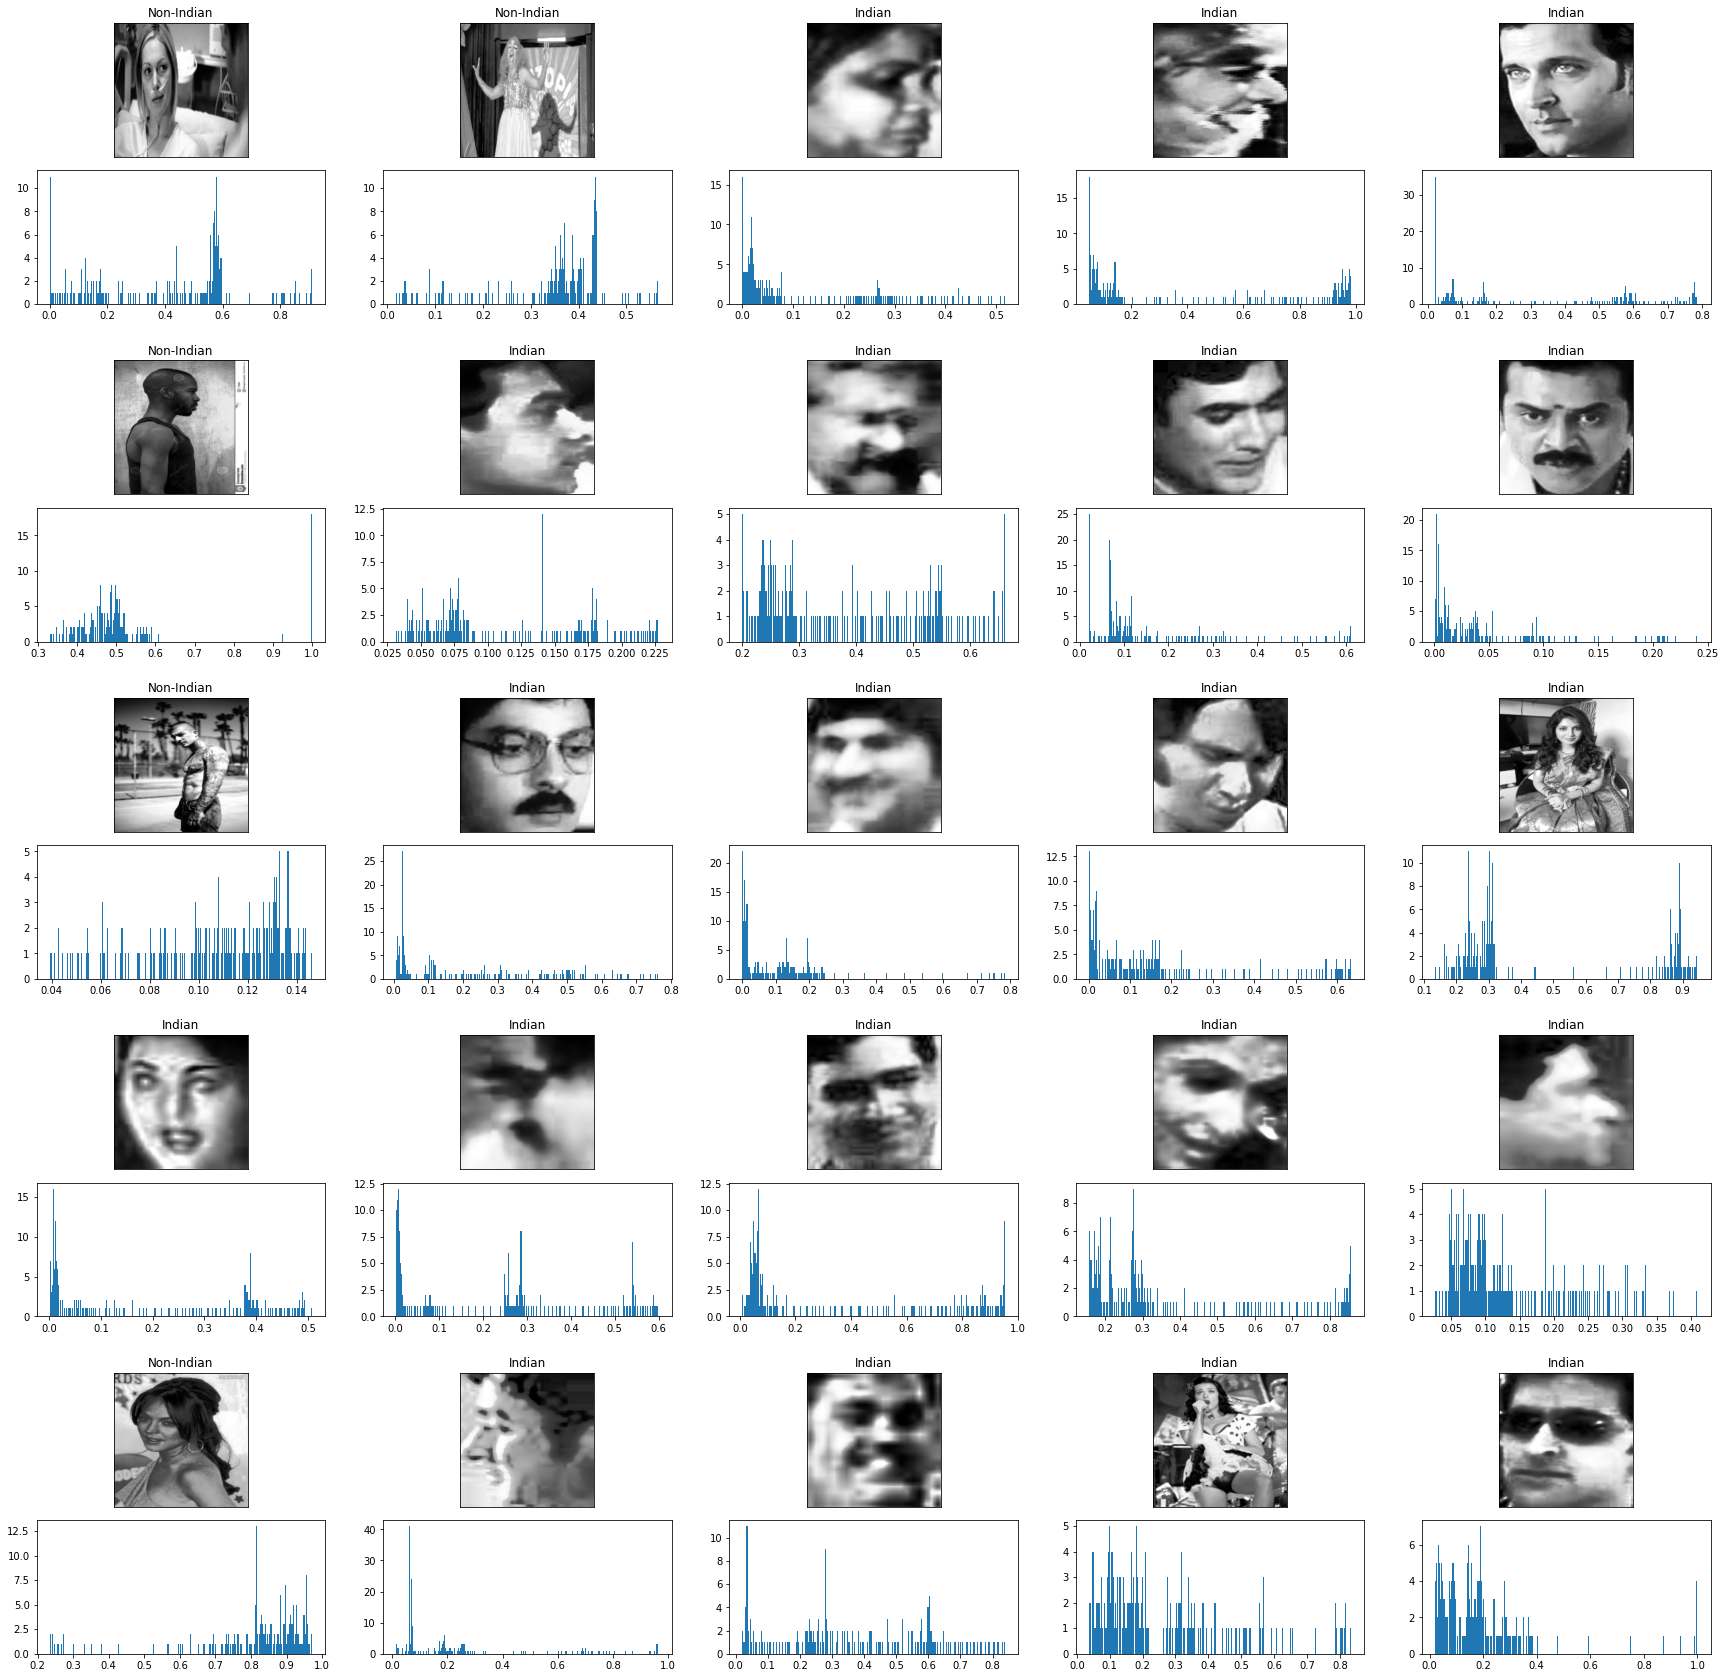

In [ ]:
fig = plot.figure(figsize=(30, 30))
outer = gridspec.GridSpec(5, 5, wspace=0.2, hspace=0.2)
s=0
for i,k in zip(plot_images,plot_labels):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,subplot_spec=outer[s], wspace=0.1, hspace=0.1)
    s+=1
    for j in range(2):
        if (j%2) == 0:
            ax = plot.Subplot(fig, inner[j])
            ax.imshow(i,cmap='gray')
            ax.set_title(k)
            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)
        else:
            ax = plot.Subplot(fig, inner[j])
            ax.hist(i[0],bins=256,histtype='bar')
            fig.add_subplot(ax)
            

fig.show()

PROCESSING THE DATA

In [ ]:
image_list = np.array(image_list)
labels = np.array(labels)

In [ ]:
image_list = image_list.reshape(image_list.shape[0],image_list.shape[1],image_list.shape[2],1)

LABEL ENCODING

In [ ]:
le = preprocessing.LabelEncoder()

le.fit(labels)

encoded_label = le.transform(labels)

TRAIN TEST SPLITTING

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(image_list, encoded_label, test_size=0.33, random_state=0)

In [ ]:
input_shape = (image_list[0].shape[0],image_list[0].shape[1],1)

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

CREATING THE MODEL

In [ ]:
Model = models.Sequential()
Model.add(Conv2D(8,(5,5),activation = 'relu',input_shape=input_shape))
Model.add(BatchNormalization())
Model.add(Conv2D(16,(5,5),activation = 'relu'))
Model.add(MaxPooling2D(5,5))
Model.add(Conv2D(24,(3,3),activation = 'relu'))
Model.add(Conv2D(32,(3,3),activation = 'relu'))
Model.add(MaxPooling2D(3,3))
Model.add(Flatten())
Model.add(Dense(32, activation='relu'))
Model.add(Dropout(0.3))
Model.add(Dense(32, activation='relu'))
Model.add(Dense(16, activation='relu'))
Model.add(Dense(16, activation='relu'))
Model.add(Dense(2,activation='softmax'))

In [ ]:
Model.compile(loss=keras.losses.categorical_crossentropy,optimizer=keras.optimizers.Adam(learning_rate=0.001),metrics=['accuracy'])

CALL BACK FUNCTIONS

In [ ]:
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping
#callbacks
#Best Save Callback
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
#Stop Model training in case of no Improvement
early_stop=EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=1, mode='auto', baseline=None, restore_best_weights=False)
# Reduce learning rate when a metric has stopped improving.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=0.0001)
callbacks_list = [checkpoint,early_stop,reduce_lr]

TRAINING THE MODEL

In [ ]:
trained = Model.fit(X_train, y_train,epochs=50,verbose=1,validation_split=0.30,callbacks=callbacks_list)

Epoch 1/50
23/23 [==============================] - 54s 2s/step - loss: 0.6159 - accuracy: 0.6755 - val_loss: 0.5315 - val_accuracy: 0.8185

Epoch 00001: val_accuracy improved from -inf to 0.81848, saving model to weights.best.hdf5
Epoch 2/50
23/23 [==============================] - 49s 2s/step - loss: 0.4039 - accuracy: 0.7996 - val_loss: 0.5278 - val_accuracy: 0.8185

Epoch 00002: val_accuracy did not improve from 0.81848
Epoch 3/50
23/23 [==============================] - 49s 2s/step - loss: 0.3782 - accuracy: 0.7777 - val_loss: 0.6465 - val_accuracy: 0.8185

Epoch 00003: val_accuracy did not improve from 0.81848
Epoch 4/50
23/23 [==============================] - 48s 2s/step - loss: 0.2209 - accuracy: 0.8817 - val_loss: 0.5819 - val_accuracy: 0.8680

Epoch 00004: val_accuracy improved from 0.81848 to 0.86799, saving model to weights.best.hdf5
Epoch 5/50
23/23 [==============================] - 48s 2s/step - loss: 0.2530 - accuracy: 0.9029 - val_loss: 0.3753 - val_accuracy: 0.8218



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 196, 196, 8)       208       
_________________________________________________________________
batch_normalization_1 (Batch (None, 196, 196, 8)       32        
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 192, 192, 16)      3216      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 38, 38, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 36, 36, 24)        3480      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 32)        6944      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 11, 11, 32)       

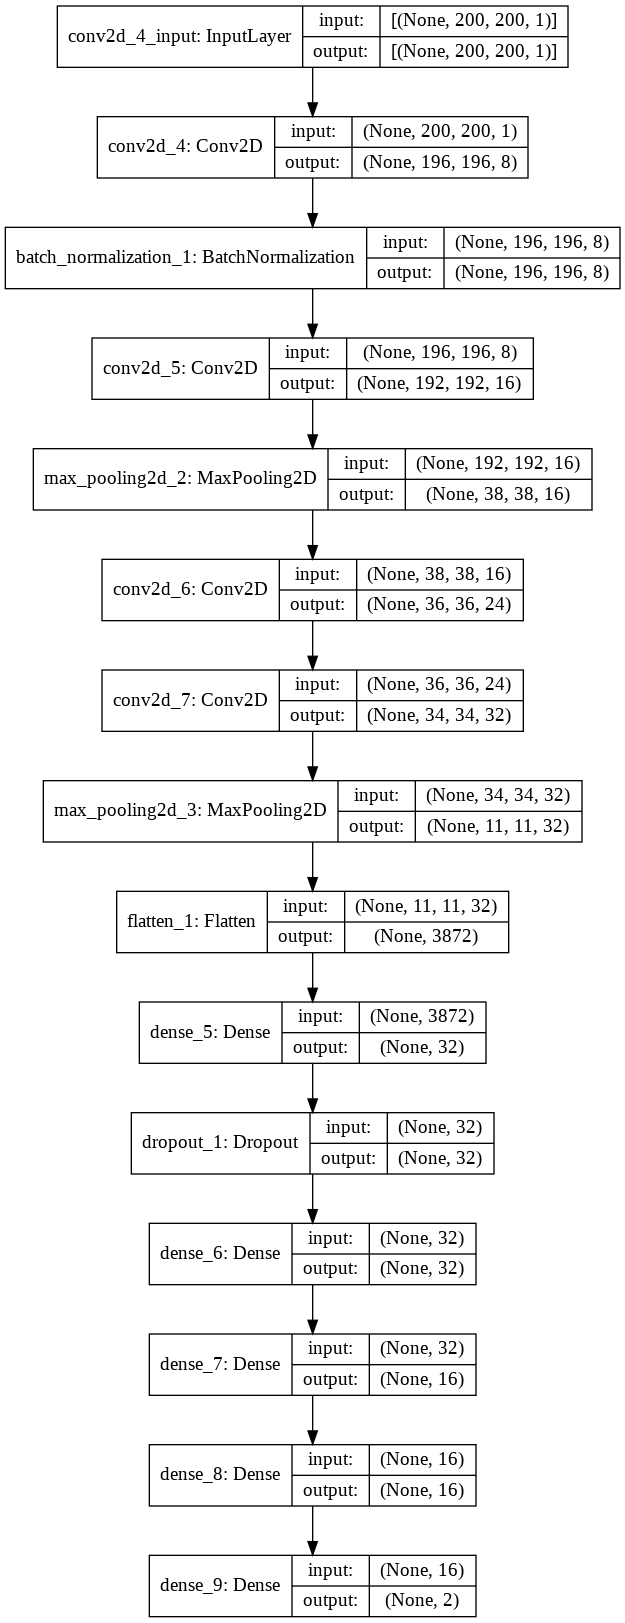

In [ ]:
Model.summary()
SVG(model_to_dot(Model).create(prog='dot', format='svg'))
Utils.plot_model(Model,to_file='model.png',show_shapes=True)

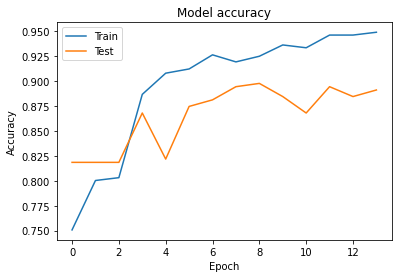

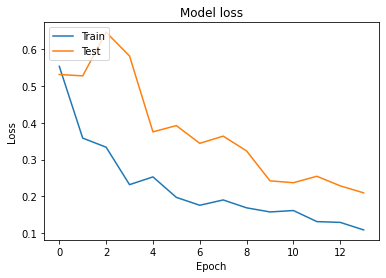

In [ ]:
plot.plot(trained.history['accuracy'])
plot.plot(trained.history['val_accuracy'])
plot.title('Model accuracy')
plot.ylabel('Accuracy')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()

plot.plot(trained.history['loss'])
plot.plot(trained.history['val_loss'])
plot.title('Model loss')
plot.ylabel('Loss')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()

EVALUATION

In [ ]:
evaluation = Model.evaluate(X_test,y_test, verbose=1)

print("Testing Accuracy: {0}\nTesting Loss: {1}".format(evaluation[0],evaluation))

16/16 [==============================] - 7s 413ms/step - loss: 0.1968 - accuracy: 0.9076
Testing Accuracy: 0.19675207138061523
Testing Loss: [0.19675207138061523, 0.9076305031776428]


PREDICTION

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


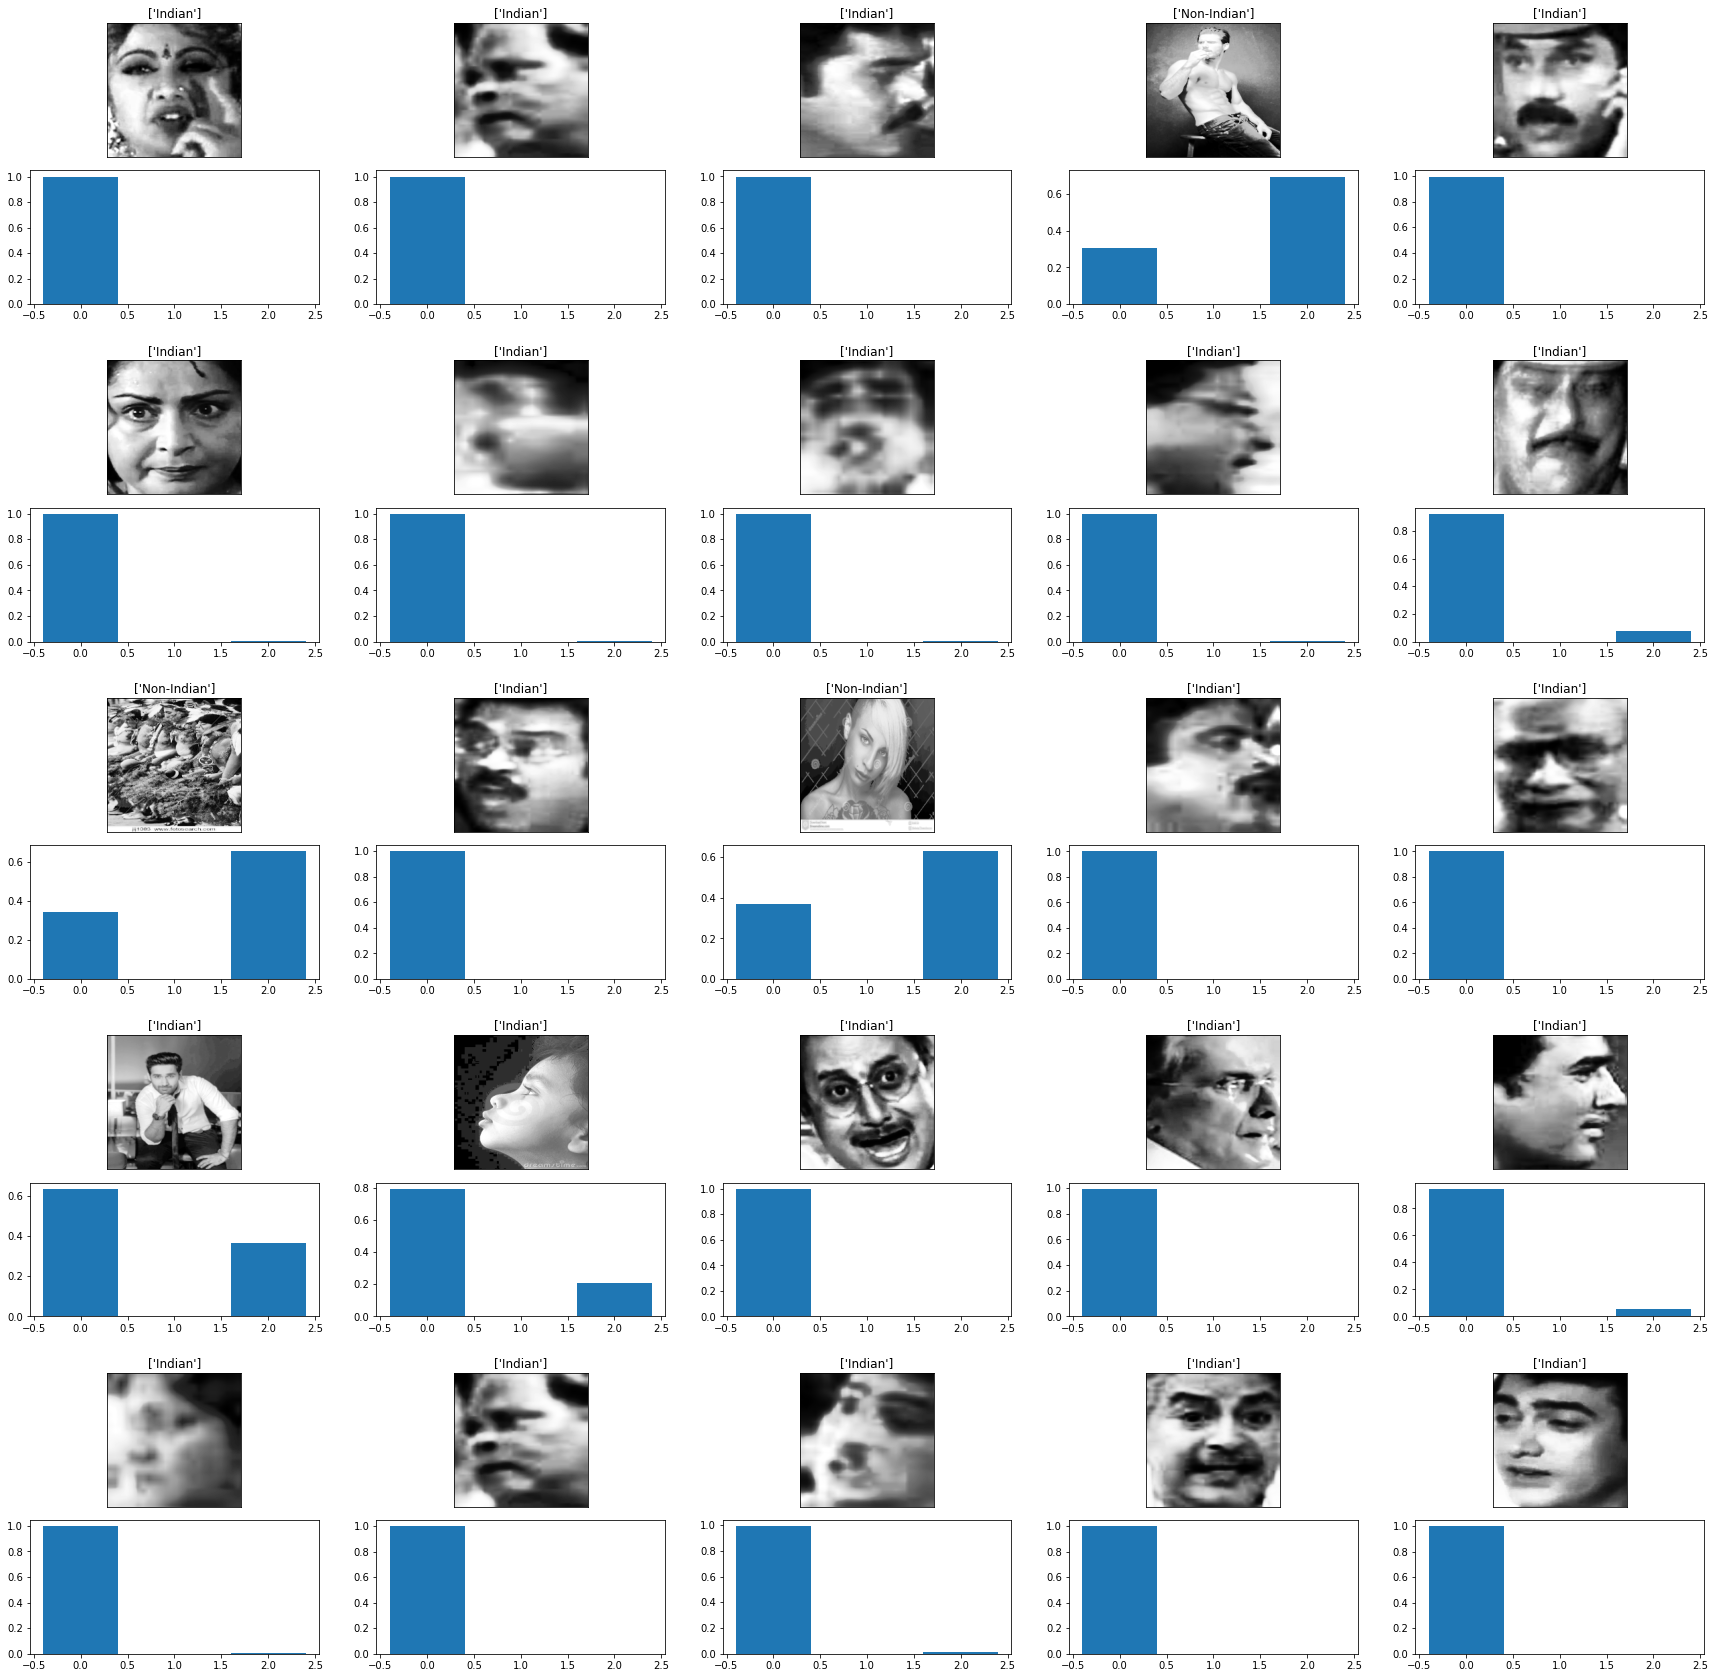

In [ ]:
fig = plot.figure(figsize=(30, 30))
outer = gridspec.GridSpec(5, 5, wspace=0.2, hspace=0.2)

for i in range(25):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,subplot_spec=outer[i], wspace=0.1, hspace=0.1)
    rnd_number = randint(0,len(X_test))
    pred_image = np.array([X_test[rnd_number]]) 
    pred_class = le.inverse_transform([Model.predict_classes(pred_image)[0]])
    pred_prob = Model.predict(pred_image).reshape(2)
    for j in range(2):
        if (j%2) == 0:
            ax = plot.Subplot(fig, inner[j])
            ax.imshow(pred_image[0].reshape(200,200),cmap='gray')
            ax.set_title(pred_class)
            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)
        else:
            ax = plot.Subplot(fig, inner[j])
            ax.bar([0,2],pred_prob)
            fig.add_subplot(ax)

fig.show()